In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [222]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

In [17]:
task = [
    'PhonemeSequence',
    'SentenceRep',
    'TIMIT'
]
ref='bipolar'


stats_paths = []
stats_paths.extend(
    BIDSPath(
        root=f'../results/{t}({ref})',
        datatype='HGA',
        suffix='coord',
        check=False,
    ).match()
    for t in task
)

stats_paths = np.concatenate(stats_paths).tolist()

coords = []
for path in tqdm(stats_paths):
    df = pd.read_csv(path)
    coords.append(df)
    
coords = pd.concat(coords)

# rename INS to 'Insula'
coords.loc[coords.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
coords.loc[coords.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
coords.loc[coords.roi == 'PrG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'PoG', 'roi'] = 'SMC'
coords.loc[coords.roi == 'Subcentral', 'roi'] = 'SMC'

coords.head()

100%|██████████| 343/343 [00:01<00:00, 312.24it/s]


,channel,x,y,z,HGA,significant,subject,task,band,description,phase,label,roi,hemi
0,D0019_ROG1-2,20.731562,-95.433053,-4.406237,-0.042141,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
1,D0019_ROG2-3,18.712896,-94.417750,6.523434,0.028593,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
2,D0019_ROG3-4,17.039880,-94.822626,17.317047,0.061983,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_Pole_occipital,OPC,R
3,D0019_ROG4-5,16.298644,-91.860079,29.446276,0.060467,True,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R
4,D0019_ROG5-6,13.397947,-84.402838,39.447554,0.018777,False,D0019,PhonemeSequence,highgamma,perception,NaN,ctx_rh_G_occipital_sup,sOccG,R


# All SMC/STG/Insula electrodes 

In [6]:
# take unique electrode out
coords_unique = coords[coords.roi.isin(['Insula', 'STG', 'SMC'])].drop_duplicates(subset=['channel'])
print('Number of electrodes: ', coords_unique.shape[0])

Number of electrodes:  838


Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 14:14:16.220 (2600.923s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x199b7590): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 14:14:16.271 (2600.975s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1099e450): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

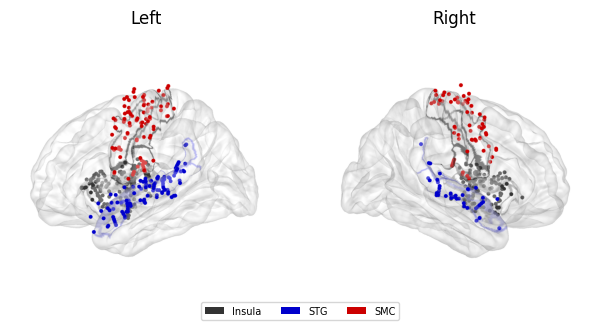

In [14]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 定义三个ROI的颜色
roi_colors = {
    'Insula': (0.2, 0.2, 0.2),    # 深灰色
    'STG': (0.0, 0.0, 0.8),       # 蓝色
    'SMC': (0.8, 0.0, 0.0),       # 红色
}

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        # Insula
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        # STG
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        # SMC
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

# 预先计算每个半球每个ROI的顶点
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_colors.keys()}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_colors.keys()}

# 创建Brain对象 - 使用pial表面
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

cord = coords_unique[['x', 'y', 'z']].values
rois = coords_unique['roi'].values

mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 加载pial表面数据用于过滤
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_tree = cKDTree(rh_coords_pial)

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)  # 找最近顶点用于过滤
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(lh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(lh_indices, lh_rois)):
        if idx in lh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极（使用原始坐标）
    for roi, color in roi_colors.items():
        roi_mask = (lh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(lh_cord[roi_mask])  # 直接使用原始坐标
            lh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)  # 找最近顶点用于过滤
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(rh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(rh_indices, rh_rois)):
        if idx in rh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极（使用原始坐标）
    for roi, color in roi_colors.items():
        roi_mask = (rh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(rh_cord[roi_mask])  # 直接使用原始坐标
            rh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 添加ROI边界
for lab in labels:
    name = lab.name

    # Insula
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.05, 0.05, 0.05), alpha=0.5)

    if ('G_temp_sup' in name):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=(0.0, 0.0, 0.8), alpha=0.5)

    smc_keys = [
        'G_precentral',
        'G_postcentral',
        'G_and_S_subcentral',
    ]
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color='black', alpha=0.7)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color='black', alpha=0.7)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=roi) for roi, color in roi_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=7)

# 关闭 Brain 对象
lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.show()

Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 14:15:04.836 (2649.540s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x12de7410): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 14:15:04.886 (2649.590s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x1cb223a0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

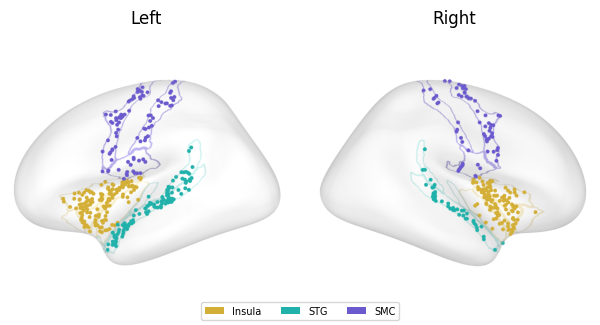

In [16]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree

# 定义三个ROI的颜色
# roi_colors = {
#     'Insula': '#81B29A',    # 深灰色
#     'STG': '#F2CC8F',       # 蓝色
#     'SMC': '#9F86C0',       # 红色
# }

roi_colors = {
    'Insula': '#D4AF37',    # 深灰色
    'STG': '#20B2AA',       # 蓝色
    'SMC': '#6A5ACD',       # 红色
}

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        # Insula
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        # STG
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        # SMC
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

# 预先计算每个半球每个ROI的顶点
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_colors.keys()}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_colors.keys()}

# 创建Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

cord = coords_unique[['x', 'y', 'z']].values
rois = coords_unique['roi'].values

mask_lh = cord[:, 0] < 0  # x < 0 为左半球
mask_rh = cord[:, 0] > 0  # x > 0 为右半球

# 加载表面数据
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_coords_infl, _ = mne.read_surface(lh_infl_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_coords_infl, _ = mne.read_surface(rh_infl_path)
rh_tree = cKDTree(rh_coords_pial)

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(lh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(lh_indices, lh_rois)):
        if idx in lh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极
    for roi, color in roi_colors.items():
        roi_mask = (lh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(lh_cord_on_infl[roi_mask])
            lh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    
    # 过滤：只保留在对应ROI label内的电极
    valid_mask = np.zeros(len(rh_cord), dtype=bool)
    for i, (idx, roi) in enumerate(zip(rh_indices, rh_rois)):
        if idx in rh_roi_vertices[roi]:
            valid_mask[i] = True
    
    # 按ROI分组绘制不同颜色的电极
    for roi, color in roi_colors.items():
        roi_mask = (rh_rois == roi) & valid_mask
        if roi_mask.any():
            cloud = pv.PolyData(rh_cord_on_infl[roi_mask])
            rh_brain._renderer.plotter.add_mesh(
                cloud,
                render_points_as_spheres=True,
                point_size=20,
                color=color,
                lighting=False,
                smooth_shading=False,
                opacity=1,
            )

# 添加ROI边界
for lab in labels:
    name = lab.name

    # Insula
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=roi_colors['Insula'], alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=roi_colors['Insula'], alpha=0.5)

    if ('G_temp_sup' in name):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=roi_colors['STG'], alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=roi_colors['STG'], alpha=0.5)

    smc_keys = [
        'G_precentral',
        'G_postcentral',
        'G_and_S_subcentral',
    ]
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=roi_colors['SMC'], alpha=0.7)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=roi_colors['SMC'], alpha=0.7)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
ax1.imshow(lh_brain.screenshot(mode="rgb"))
ax1.axis("off")
ax1.set_title("Left")

ax2.imshow(rh_brain.screenshot(mode="rgb"))
ax2.axis("off")
ax2.set_title("Right")

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=roi) for roi, color in roi_colors.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=7)

# 关闭 Brain 对象
lh_brain.close()
rh_brain.close()

plt.savefig('../img/fig1/electrode_distribution.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Signifiant HGA: Listening

In [201]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

# 1. 加载所有 perception 和 passive 的 time 数据
task = ['PhonemeSequence', 'SentenceRep', 'TIMIT']
ref = 'bipolar'

time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',  # 注意这里改成 'time'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename INS to 'Insula'
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'

# combine HG to STG
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'

# rename CG to Cingulate cortex
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

listen_hga = time_data[(time_data['time'] >= 0) & 
                       (time_data['time'] <= 0.5)].groupby('channel').agg({
    'value': 'mean',  
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'phase': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'task': 'first'
}).reset_index()

listen_hga.rename(columns={'value': 'peak_HGA'}, inplace=True)

listen_hga = listen_hga[~listen_hga.description.isin(['production'])]
listen_hga = listen_hga[~listen_hga.phase.isin(['Go','Response'])]

listen_hga.head()

100%|██████████| 335/335 [00:04<00:00, 82.72it/s] 


,channel,peak_HGA,x,y,z,roi,phase,hemi,subject,description,task
0,D0005_LTG13-14,0.259282,-67.238742,-17.127162,-3.621204,STG,Audio,L,D0005,JL,SentenceRep
1,D0005_LTG14-15,1.006196,-68.886726,-28.295294,0.243498,STG,Audio,L,D0005,JL,SentenceRep
2,D0005_LTG15-16,1.113843,-69.639740,-38.151283,4.609248,STG,Audio,L,D0005,JL,SentenceRep
3,D0005_LTG16-19,0.234122,-63.894918,-19.994242,-9.960822,MTG,Audio,L,D0005,JL,SentenceRep
4,D0005_LTG2-3,0.123613,-56.048491,15.454424,-8.878516,STG,Audio,L,D0005,JL,SentenceRep


In [202]:
listen_hga = listen_hga[listen_hga.roi.isin(['STG','Insula','SMC'])]
listen_hga.head()
listen_hga.task.unique()

array(['SentenceRep', 'PhonemeSequence', 'TIMIT'], dtype=object)

Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:40:46.727 (25791.431s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x70b23430): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:40:46.768 (25791.471s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x6d20c130): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning

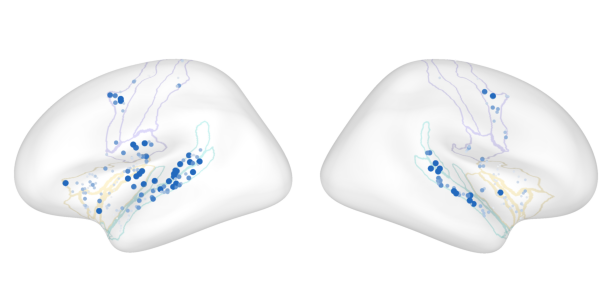

In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

roi_names = ['Insula', 'STG', 'SMC']
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_names}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_names}

# 创建Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

# 从 listen_hga 获取数据
cord = listen_hga[['x', 'y', 'z']].values
rois = listen_hga['roi'].values
hga_values = listen_hga['peak_HGA'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = blues
vmin, vmax = 0, np.percentile(hga_values, 95)
vmax = 1
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 10, 30

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

# 加载表面数据
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_coords_infl, _ = mne.read_surface(lh_infl_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_coords_infl, _ = mne.read_surface(rh_infl_path)
rh_tree = cKDTree(rh_coords_pial)

# 为每个 ROI 构建 KDTree，用于计算距离
def build_roi_trees(coords_pial, roi_vertices_dict):
    """为每个 ROI 构建 KDTree"""
    roi_trees = {}
    for roi, vertices in roi_vertices_dict.items():
        if len(vertices) > 0:
            roi_coords = coords_pial[list(vertices)]
            roi_trees[roi] = cKDTree(roi_coords)
    return roi_trees

lh_roi_trees = build_roi_trees(lh_coords_pial, lh_roi_vertices)
rh_roi_trees = build_roi_trees(rh_coords_pial, rh_roi_vertices)

# 距离阈值（单位：mm），电极到 ROI 的最小距离小于此值则保留
distance_threshold = 10.0  # 可调整

def get_valid_mask_with_distance(coords, rois_arr, roi_trees, threshold):
    """基于距离阈值判断电极是否足够接近对应 ROI"""
    valid_mask = np.zeros(len(coords), dtype=bool)
    for i, (coord, roi) in enumerate(zip(coords, rois_arr)):
        if roi in roi_trees:
            dist, _ = roi_trees[roi].query(coord)
            if dist <= threshold:
                valid_mask[i] = True
    return valid_mask

def add_electrodes_with_size(brain, coords, hga_vals, cmap, norm, size_min, size_max):
    for i in range(len(coords)):
        pt = coords[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
            smooth_shading=False,
            opacity=1,
        )

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    lh_hga = hga_values[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    
    # 使用距离阈值判断
    valid_mask = get_valid_mask_with_distance(lh_cord, lh_rois, lh_roi_trees, distance_threshold)
    print(f"左半球: {valid_mask.sum()}/{len(lh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = lh_cord_on_infl[valid_mask]
        valid_hga = lh_hga[valid_mask]
        add_electrodes_with_size(lh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    rh_hga = hga_values[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    
    valid_mask = get_valid_mask_with_distance(rh_cord, rh_rois, rh_roi_trees, distance_threshold)
    print(f"右半球: {valid_mask.sum()}/{len(rh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = rh_cord_on_infl[valid_mask]
        valid_hga = rh_hga[valid_mask]
        add_electrodes_with_size(rh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 添加ROI边界
for lab in labels:
    name = lab.name
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
    if 'G_temp_sup' in name:
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
    smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")

lh_brain.close()
rh_brain.close()

plt.savefig('../img/fig1/fig1_peak_listening.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Significant HGA: Production

In [215]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

# 1. 加载所有 time 数据
task = ['PhonemeSequence', 'SentenceRep', 'TIMIT']
ref = 'bipolar'

time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',
            check=False,
        ).match()
    )

# 2. 加载数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename ROIs
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

# 3. 先筛选 speak/production 数据，再 groupby
# 排除 perception 和 passive
speak_data = time_data[~time_data.description.isin(['perception', 'passive'])]

# 排除 SentenceRep 的 Go 和 Audio phase（保留 Response 和 NaN）
mask = speak_data.phase.isna() | (~speak_data.phase.isin(['Go', 'Audio']))
speak_data = speak_data[mask]

# 只保留 time >= -0.5
speak_data = speak_data[(speak_data['time'] <= 0) & 
                        (speak_data['time'] >= -0.5)]

print(f"筛选后数据量: {len(speak_data)}")
print(f"description 分布: {speak_data.description.unique()}")
print(f"phase 分布: {speak_data.phase.unique()}")
print(f"task 分布: {speak_data.task.unique()}")

# 4. groupby 计算 peak HGA
speak_hga = speak_data.groupby('channel').agg({
    'value': 'mean',  
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'task': 'first'
}).reset_index()

speak_hga.rename(columns={'value': 'HGA'}, inplace=True)
speak_hga.head()

100%|██████████| 335/335 [00:03<00:00, 84.17it/s] 


筛选后数据量: 111670
description 分布: ['production' 'LS']
phase 分布: [nan 'Response']
task 分布: ['PhonemeSequence' 'SentenceRep']


,channel,HGA,x,y,z,roi,hemi,subject,description,task
0,D0005_LTG14-15,-0.072873,-68.886726,-28.295294,0.243498,STG,L,D0005,LS,SentenceRep
1,D0005_LTG15-16,-0.176992,-69.639740,-38.151283,4.609248,STG,L,D0005,LS,SentenceRep
2,D0005_LTG24-26,0.084555,-57.666666,-21.463809,-25.843526,ITG,L,D0005,LS,SentenceRep
3,D0005_LTG29-30,0.183034,-54.534528,-29.265764,-28.078430,ITG,L,D0005,LS,SentenceRep
4,D0005_LTG30-31,0.258022,-55.770381,-38.615740,-23.875112,ITG,L,D0005,LS,SentenceRep


In [216]:
speak_hga = speak_hga[speak_hga.roi.isin(['STG','Insula','SMC'])]
speak_hga.head()
speak_hga.task.unique()

array(['SentenceRep', 'PhonemeSequence'], dtype=object)

Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:44:45.065 (26029.769s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x195b47d0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:44:45.114 (26029.817s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0xa0df150): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning:

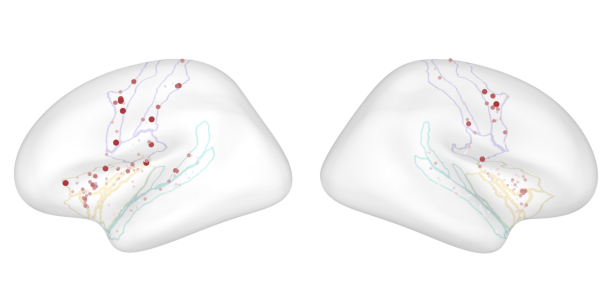

In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

roi_names = ['Insula', 'STG', 'SMC']
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_names}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_names}

# 创建Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

# 从 speak_hga 获取数据
cord = speak_hga[['x', 'y', 'z']].values
rois = speak_hga['roi'].values
hga_values = speak_hga['HGA'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
vmin, vmax = 0, np.percentile(hga_values, 95)
vmax = 1
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 10, 30

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

# 加载表面数据
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_coords_infl, _ = mne.read_surface(lh_infl_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_coords_infl, _ = mne.read_surface(rh_infl_path)
rh_tree = cKDTree(rh_coords_pial)

# 为每个 ROI 构建 KDTree，用于计算距离
def build_roi_trees(coords_pial, roi_vertices_dict):
    roi_trees = {}
    for roi, vertices in roi_vertices_dict.items():
        if len(vertices) > 0:
            roi_coords = coords_pial[list(vertices)]
            roi_trees[roi] = cKDTree(roi_coords)
    return roi_trees

lh_roi_trees = build_roi_trees(lh_coords_pial, lh_roi_vertices)
rh_roi_trees = build_roi_trees(rh_coords_pial, rh_roi_vertices)

# 距离阈值（单位：mm）
distance_threshold = 10.0

def get_valid_mask_with_distance(coords, rois_arr, roi_trees, threshold):
    valid_mask = np.zeros(len(coords), dtype=bool)
    for i, (coord, roi) in enumerate(zip(coords, rois_arr)):
        if roi in roi_trees:
            dist, _ = roi_trees[roi].query(coord)
            if dist <= threshold:
                valid_mask[i] = True
    return valid_mask

def add_electrodes_with_size(brain, coords, hga_vals, cmap, norm, size_min, size_max):
    for i in range(len(coords)):
        pt = coords[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
            smooth_shading=False,
            opacity=1,
        )

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    lh_hga = hga_values[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    
    valid_mask = get_valid_mask_with_distance(lh_cord, lh_rois, lh_roi_trees, distance_threshold)
    print(f"左半球: {valid_mask.sum()}/{len(lh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = lh_cord_on_infl[valid_mask]
        valid_hga = lh_hga[valid_mask]
        add_electrodes_with_size(lh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    rh_hga = hga_values[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    
    valid_mask = get_valid_mask_with_distance(rh_cord, rh_rois, rh_roi_trees, distance_threshold)
    print(f"右半球: {valid_mask.sum()}/{len(rh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = rh_cord_on_infl[valid_mask]
        valid_hga = rh_hga[valid_mask]
        add_electrodes_with_size(rh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 添加ROI边界
for lab in labels:
    name = lab.name
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
    if 'G_temp_sup' in name:
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
    smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")

lh_brain.close()
rh_brain.close()

plt.savefig('../img/fig1/fig1_peak_speaking.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Mime

In [219]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

# 1. 加载所有 time 数据
task = ['PhonemeSequence', 'SentenceRep', 'TIMIT']
ref = 'bipolar'

time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',
            check=False,
        ).match()
    )

# 2. 加载数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename ROIs
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

# 3. 先筛选 speak/production 数据，再 groupby
# 排除 perception 和 passive
mime_hga = time_data[time_data.description.isin(['LM'])]
mask = (mime_hga.phase.isin(['Go']))
mime_hga = mime_hga[mask]

# 只保留 time >= -0.5
mime_hga = mime_hga[(mime_hga['time'] <= 0) & 
                        (mime_hga['time'] >= -0.5)]

print(f"筛选后数据量: {len(mime_hga)}")
print(f"description 分布: {mime_hga.description.unique()}")
print(f"phase 分布: {mime_hga.phase.unique()}")
print(f"task 分布: {mime_hga.task.unique()}")

# 4. groupby 计算 peak HGA
mime_hga = mime_hga.groupby('channel').agg({
    'value': 'mean',  
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'task': 'first'
}).reset_index()

mime_hga.rename(columns={'value': 'HGA'}, inplace=True)
mime_hga.head()

100%|██████████| 335/335 [00:04<00:00, 83.35it/s] 


筛选后数据量: 35165
description 分布: ['LM']
phase 分布: ['Go']
task 分布: ['SentenceRep']


,channel,HGA,x,y,z,roi,hemi,subject,description,task
0,D0005_LTG13-14,0.034553,-67.238742,-17.127162,-3.621204,STG,L,D0005,LM,SentenceRep
1,D0005_LTG14-15,-0.028136,-68.886726,-28.295294,0.243498,STG,L,D0005,LM,SentenceRep
2,D0005_LTG23-24,-0.148368,-64.682055,-45.475979,-12.267161,MTG,L,D0005,LM,SentenceRep
3,D0005_LTG24-26,-0.053393,-57.666666,-21.463809,-25.843526,ITG,L,D0005,LM,SentenceRep
4,D0005_LTG26-27,0.058628,-51.279532,0.537674,-42.737752,TP,L,D0005,LM,SentenceRep


In [220]:
mime_hga = mime_hga[mime_hga.roi.isin(['Insula','STG','SMC'])]
mime_hga.head()
mime_hga.task.unique()

array(['SentenceRep'], dtype=object)

Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:47:24.237 (26188.940s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x58825600): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-07 20:47:24.297 (26189.000s) [    7F5127FAF440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x58825600): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning

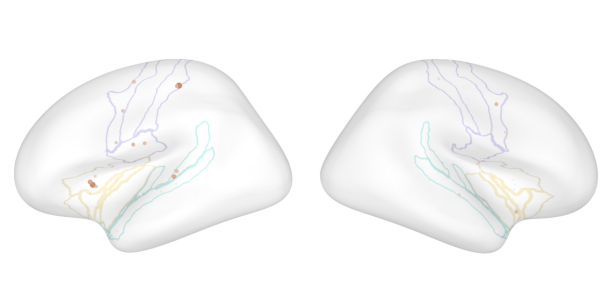

In [ ]:
from IPython.display import display
from PIL import Image
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取labels用于过滤电极
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# 构建每个ROI对应的label顶点集合
def get_roi_vertices(labels, roi_name, hemi):
    """获取指定ROI在指定半球的所有顶点"""
    vertices = set()
    for lab in labels:
        name = lab.name
        if lab.hemi != hemi:
            continue
        if roi_name == 'Insula' and 'ins' in name.lower():
            vertices.update(lab.vertices)
        elif roi_name == 'STG' and 'G_temp_sup' in name:
            vertices.update(lab.vertices)
        elif roi_name == 'SMC':
            smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
            if any(k in name for k in smc_keys):
                vertices.update(lab.vertices)
    return vertices

roi_names = ['Insula', 'STG', 'SMC']
lh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'lh') for roi in roi_names}
rh_roi_vertices = {roi: get_roi_vertices(labels, roi, 'rh') for roi in roi_names}

# 创建Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="lh", background="white", show=False,
    cortex=(0.95, 0.95, 0.95), alpha=0.3, size=(600*cm, 600*cm)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="inflated",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.3, size=(600*cm, 600*cm)
)

# 从 mime_hga 获取数据
cord = mime_hga[['x', 'y', 'z']].values
rois = mime_hga['roi'].values
hga_values = mime_hga['HGA'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
vmin, vmax = 0, np.percentile(hga_values, 95)
vmax = 1
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 10, 30

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

# 加载表面数据
lh_pial_path = f"{recon_dir}/fsaverage/surf/lh.pial"
lh_infl_path = f"{recon_dir}/fsaverage/surf/lh.inflated"
lh_coords_pial, _ = mne.read_surface(lh_pial_path)
lh_coords_infl, _ = mne.read_surface(lh_infl_path)
lh_tree = cKDTree(lh_coords_pial)

rh_pial_path = f"{recon_dir}/fsaverage/surf/rh.pial"
rh_infl_path = f"{recon_dir}/fsaverage/surf/rh.inflated"
rh_coords_pial, _ = mne.read_surface(rh_pial_path)
rh_coords_infl, _ = mne.read_surface(rh_infl_path)
rh_tree = cKDTree(rh_coords_pial)

# 为每个 ROI 构建 KDTree，用于计算距离
def build_roi_trees(coords_pial, roi_vertices_dict):
    roi_trees = {}
    for roi, vertices in roi_vertices_dict.items():
        if len(vertices) > 0:
            roi_coords = coords_pial[list(vertices)]
            roi_trees[roi] = cKDTree(roi_coords)
    return roi_trees

lh_roi_trees = build_roi_trees(lh_coords_pial, lh_roi_vertices)
rh_roi_trees = build_roi_trees(rh_coords_pial, rh_roi_vertices)

# 距离阈值（单位：mm）
distance_threshold = 10.0

def get_valid_mask_with_distance(coords, rois_arr, roi_trees, threshold):
    valid_mask = np.zeros(len(coords), dtype=bool)
    for i, (coord, roi) in enumerate(zip(coords, rois_arr)):
        if roi in roi_trees:
            dist, _ = roi_trees[roi].query(coord)
            if dist <= threshold:
                valid_mask[i] = True
    return valid_mask

def add_electrodes_with_size(brain, coords, hga_vals, cmap, norm, size_min, size_max):
    for i in range(len(coords)):
        pt = coords[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
            smooth_shading=False,
            opacity=1,
        )

# 处理左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_rois = rois[mask_lh]
    lh_hga = hga_values[mask_lh]
    _, lh_indices = lh_tree.query(lh_cord)
    lh_cord_on_infl = lh_coords_infl[lh_indices]
    
    valid_mask = get_valid_mask_with_distance(lh_cord, lh_rois, lh_roi_trees, distance_threshold)
    print(f"左半球: {valid_mask.sum()}/{len(lh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = lh_cord_on_infl[valid_mask]
        valid_hga = lh_hga[valid_mask]
        add_electrodes_with_size(lh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 处理右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_rois = rois[mask_rh]
    rh_hga = hga_values[mask_rh]
    _, rh_indices = rh_tree.query(rh_cord)
    rh_cord_on_infl = rh_coords_infl[rh_indices]
    
    valid_mask = get_valid_mask_with_distance(rh_cord, rh_rois, rh_roi_trees, distance_threshold)
    print(f"右半球: {valid_mask.sum()}/{len(rh_cord)} 电极通过距离阈值 ({distance_threshold}mm)")
    
    if valid_mask.any():
        valid_coords = rh_cord_on_infl[valid_mask]
        valid_hga = rh_hga[valid_mask]
        add_electrodes_with_size(rh_brain, valid_coords, valid_hga, cmap, norm, size_min, size_max)

# 添加ROI边界
for lab in labels:
    name = lab.name
    if 'ins' in name.lower():
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=insula_color, alpha=0.5)
    if 'G_temp_sup' in name:
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=stg_color, alpha=0.5)
    smc_keys = ['G_precentral', 'G_postcentral', 'G_and_S_subcentral']
    if any(k in name for k in smc_keys):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=True, color=smc_color, alpha=0.5)

for brain in (lh_brain, rh_brain):
    brain.show_view(view="lateral", distance=400)
    brain._renderer.plotter.window_size = [1400, 1400]

# 绘图
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))
axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")

lh_brain.close()
rh_brain.close()

plt.savefig('../img/fig1/fig1_peak_mime.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()